In [1]:
import bayes3d as b
import jax.numpy as jnp
import jax
import os
import matplotlib.pyplot as plt
import matplotlib

In [2]:
b.setup_renderer

<function bayes3d.renderer.setup_renderer(intrinsics, num_layers=1024)>

In [3]:

intrinsics = b.Intrinsics(
    height=300,
    width=300,
    fx=500.0, fy=500.0,
    cx=150.0, cy=150.0,
    near=0.01, far=10.0
)

b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=3.0/1000.0)

# b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/10000000000.0)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (320, 320, 1024)


In [4]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [5]:
IDX = 15 #11
frames = 200
dots = 250
pc = jnp.array(b.RENDERER.meshes[IDX].vertices)
lifetime = 5 #keep 1-1/5 of the dots after every frame update

pc_subsample_start = pc[jax.random.choice(jax.random.PRNGKey(10), jnp.arange(pc.shape[0]), shape=(dots,) )] #want 1000 dots total
pc_replacements = pc[jax.random.choice(jax.random.PRNGKey(0), jnp.arange(pc.shape[0]), shape=(frames,dots//lifetime) )]

pc_subsamples = jnp.zeros((frames,*pc_subsample_start.shape))
pc_subsamples = pc_subsamples.at[0,...].set(pc_subsample_start)
for i in range(1,frames):
    pc_subsamples = pc_subsamples.at[i,...].set(pc_subsamples[i-1,...])
    sampled_indices = jax.random.choice(jax.random.PRNGKey(i), jnp.arange(dots), shape=(dots//lifetime,) )
    pc_subsamples = pc_subsamples.at[i,sampled_indices,...].set(pc_replacements[i,...])

print(pc_subsamples.shape)
b.show_cloud("1",pc)

(200, 250, 3)


In [6]:
poses = jnp.array([b.t3d.inverse_pose(b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 2.0, 0.0]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
)) @ b.t3d.transform_from_axis_angle(jnp.array([0.0, 0.0, 1.0]), angle) for angle in jnp.linspace(0.0, 4*jnp.pi, frames)])

print(poses.shape)

(200, 4, 4)


In [7]:
def render_point_light(pose, pc_subsample):
    point_cloud_img = b.RENDERER.render_single_object(pose,  jnp.int32(IDX))[:,:,:3]
    point_cloud_img_in_object_frame = b.t3d.apply_transform(point_cloud_img, b.t3d.inverse_pose(pose))
    
    dots = jnp.zeros(point_cloud_img_in_object_frame.shape)

    #pc_subs = pc_subsample[jax.random.choice(jax.random.PRNGKey(10), jnp.arange(pc_subsample.shape[0]), shape=(900,), replace=False )]

    #modify to randomly select from the rendered pixel mask instead!!
    #add time constancy term and decay terms
    #might need to do this directly from the rendered image space ...
    distances_to_keypoints = (
        jnp.linalg.norm(point_cloud_img_in_object_frame[:, :,None,...] - pc_subsample[None, None,:,...],
        axis=-1
    ))
    index_of_nearest_keypoint = distances_to_keypoints.argmin(2)
    distance_to_nearest_keypoints = distances_to_keypoints.min(2)

    DISTANCE_THRESHOLD = 0.01
    valid_match_mask = (distance_to_nearest_keypoints < DISTANCE_THRESHOLD)[...,None]
    return valid_match_mask, point_cloud_img_in_object_frame, distance_to_nearest_keypoints, dots
render_point_light_parallel_jit = jax.jit(jax.vmap(render_point_light, in_axes=(0,0), out_axes=0))



In [8]:
print(poses.shape)

(200, 4, 4)


(200, 300, 300, 1)


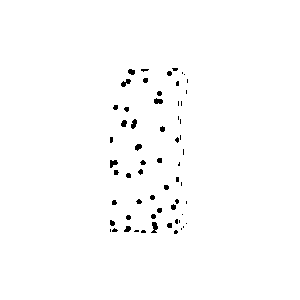

In [9]:
images, a, c, o = render_point_light_parallel_jit(poses, pc_subsamples)
print(images.shape)
b.get_depth_image(images[0,...,2] * 1.0, cmap=matplotlib.colormaps['Greys'])

In [11]:
a.shape

(200, 300, 300, 3)

In [12]:
o.shape

(200, 300, 300, 3)

In [13]:
images[0,...,2]*1.0

Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32, weak_type=True)

In [14]:
# point_cloud_normalized = pc_subsampled / pc_subsampled[:, 2].reshape(-1, 1)
# temp1 = point_cloud_normalized[:, :2] * jnp.array([intrinsics.fx,intrinsics.fy])
# temp2 = temp1 + jnp.array([intrinsics.cx, intrinsics.cy])
# print([intrinsics.fx, intrinsics.fy])
# with jnp.printoptions(threshold=jnp.inf):
#     print(jnp.round(temp2))


(300, 300)


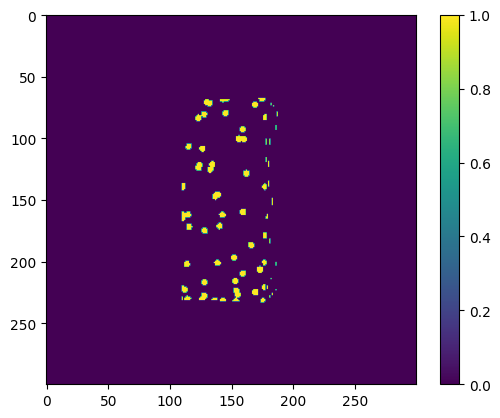

In [25]:

print(images[0,:,:,0].shape)
plt.imshow(images[0,:,:,0]*1)
plt.colorbar()

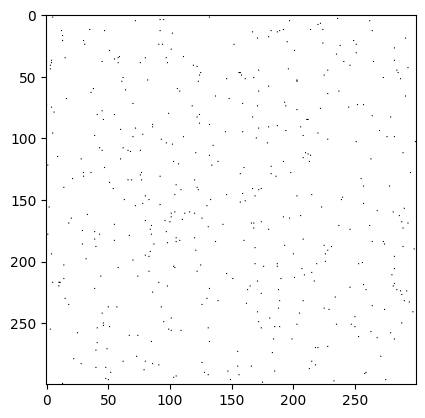

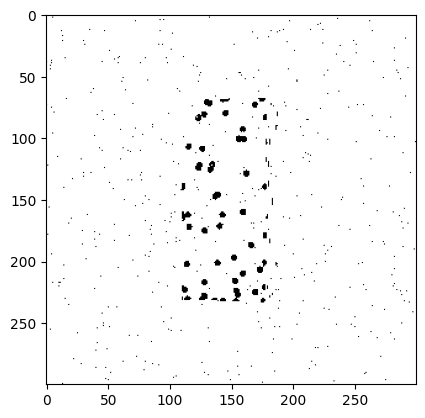

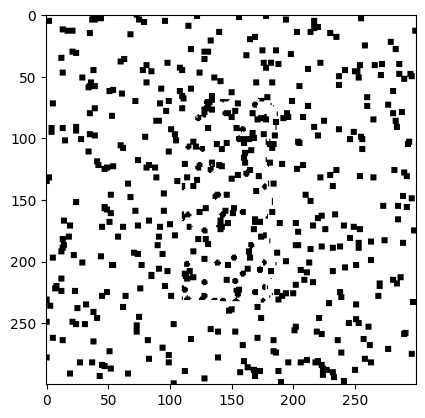

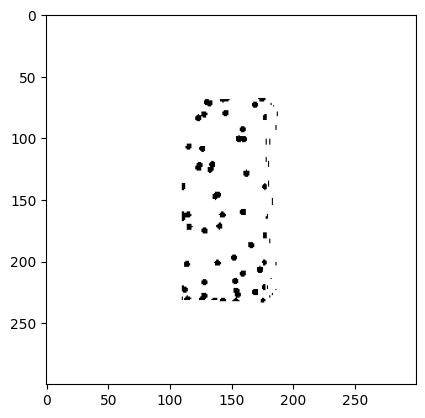

In [26]:
flips = (jax.random.uniform(jax.random.PRNGKey(10),shape=images.shape) < 0.005) #was 0

x, y, z, w = jnp.meshgrid(*[jnp.arange(l) for l in images.shape])

def circles(flips_xy, radius):
    centers = jnp.array((flips_xy>0).nonzero(size=50000,fill_value=jnp.inf))
    xymesh = jnp.array(jnp.meshgrid(*[jnp.arange(l) for l in flips_xy.shape]))
    #print(centers.shape)
    #print(xymesh.shape)
    distances_to_keypoints = (
        jnp.linalg.norm(xymesh[:, :,:,None] - centers[:,None, None,:],
        axis=0
    ))
    index_of_nearest_keypoint = distances_to_keypoints.argmin(2)
    distance_to_nearest_keypoints = distances_to_keypoints.min(2)

    DISTANCE_THRESHOLD = radius
    valid_match_mask = (distance_to_nearest_keypoints < DISTANCE_THRESHOLD)[...,None]
    return valid_match_mask


#mask = [circles(flips[m,:,:,0],3) for m in range(len(flips))]

circles_parallel_jit = jax.jit(jax.vmap(circles, in_axes=(0,None)))
mask = circles_parallel_jit(flips[:,:,:,1], 3)
#need to specify the amount of nonzero for parallelization

plt.imshow(flips[0,:,:,0]*1.0,cmap=matplotlib.colormaps['Greys'])
noisy_data = (images * jnp.logical_not(flips)) + (jnp.logical_not(images) * flips)
plt.figure()
plt.imshow(noisy_data[0,:,:,0]*1.0,cmap=matplotlib.colormaps['Greys'])
circle_data = (images * jnp.logical_not(flips)) + (jnp.logical_not(images) * mask)
plt.figure()
plt.imshow(circle_data[0,:,:,0]*1.0,cmap=matplotlib.colormaps['Greys'])
plt.figure()
plt.imshow(images[0,:,:,0]*1.0,cmap=matplotlib.colormaps['Greys'])


In [27]:
print(circle_data.shape)

(200, 300, 300, 1)


In [28]:
print(images.shape)

(200, 300, 300, 1)


In [29]:
merge = jnp.concatenate((images,circle_data),axis=2)

In [30]:
viz = [b.get_depth_image(point_light_image * 1.0, cmap=matplotlib.colormaps['Greys']) for point_light_image in circle_data ]
b.make_gif_from_pil_images(viz, "out.gif")

In [31]:
viz = [b.get_depth_image(point_light_image * 1.0, cmap=matplotlib.colormaps['Greys']) for point_light_image in images ]
b.make_gif_from_pil_images(viz, "out_clean.gif")

In [32]:
viz = [b.get_depth_image(point_light_image * 1.0, cmap=matplotlib.colormaps['Greys']) for point_light_image in merge ]
b.make_gif_from_pil_images(viz, "out_merge.gif")

In [19]:
images

Array([[[[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        ...,

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]]],


       [[[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [Fa

In [20]:
jnp.logical_not(images)

Array([[[[ True],
         [ True],
         [ True],
         ...,
         [ True],
         [ True],
         [ True]],

        [[ True],
         [ True],
         [ True],
         ...,
         [ True],
         [ True],
         [ True]],

        [[ True],
         [ True],
         [ True],
         ...,
         [ True],
         [ True],
         [ True]],

        ...,

        [[ True],
         [ True],
         [ True],
         ...,
         [ True],
         [ True],
         [ True]],

        [[ True],
         [ True],
         [ True],
         ...,
         [ True],
         [ True],
         [ True]],

        [[ True],
         [ True],
         [ True],
         ...,
         [ True],
         [ True],
         [ True]]],


       [[[ True],
         [ True],
         [ True],
         ...,
         [ True],
         [ True],
         [ True]],

        [[ True],
         [ True],
         [ True],
         ...,
         [ True],
         [ True],
         [ T